In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import RANSACRegressor

from cvae.build import forward_keypoint

cvae/build.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/qinzy/anaconda3/envs/kptog/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/qinzy/anaconda3/envs/kptog/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/qinzy/anaconda3/envs/kptog/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/qinzy/anaconda3/envs/kptog/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/qinzy/anaconda3/envs/kptog/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in

In [10]:
name = 'keto_wooden_powerdrill'
depth = np.load(open('keto_images/{}_depth.npy'.format(name, 'rb')))
image = np.load(open('keto_images/{}_rgb.npy'.format(name, 'rb')))

In [3]:
params = {'fx': 372.66, 'tx': 241.20, 'fy': 368.62, 'ty': 214.19}

In [4]:
def depth_to_point_cloud(depth, image, params, z_min=0.00, z_max=0.20):
    height, width = depth.shape
    u = np.tile(np.arange(width).reshape([1, width]), [height, 1])
    v = np.tile(np.arange(height).reshape([height, 1]), [1, width])
    u = np.reshape(u, [height, width, 1])
    v = np.reshape(v, [height, width, 1])
    z = np.reshape(depth, [height, width, 1])
    x = (u - params['tx']) * z / params['fx']
    y = (v - params['ty']) * z / params['fy']
    mask = np.logical_and(z > z_min, z < z_max).flatten()
    point_cloud = np.concatenate([x, y, z], axis=2)
    p = np.reshape(point_cloud, [-1, 3])[mask]
    c = np.reshape(image, [-1, 3])[mask]
    return p, c

def segment_object(p, c, r=0.03, num_out=1024):
    num_points = p.shape[0]
    reg = RANSACRegressor().fit(p[:, :2], p[:, 2])
    z_plane = reg.predict(p[:, :2])
    mask = p[:, 2] < z_plane - 8e-4
    mask = np.logical_and(mask, np.linalg.norm(p[:, :2], axis=1) < r)
    p_obj, c_obj = p[mask], c[mask]
    indices = np.random.randint(low=0, high=p_obj.shape[0], size=num_out)
    p_obj, c_obj = p_obj[indices], c_obj[indices]
    return p_obj, c_obj

def visualize_keypoints(point_cloud,
                        color,
                        keypoints,
                        prefix,
                        name,
                        plot_lim=2,
                        point_size=5):
    [grasp_point, funct_point, funct_vect] = keypoints
    fig = plt.figure(figsize=(6, 6))
    xs = point_cloud[:, 0]
    ys = point_cloud[:, 1]
    zs = point_cloud[:, 2]

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, s=point_size, c=color/255.0, marker='.')
    ax.set_axis_off()
    ax.grid(False)
    ax.view_init(85, 20)
    #plt.savefig(os.path.join(prefix, '{}_point_cloud.png'.format(name)))
    plt.show()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.scatter(xs, ys, s=point_size, c=color/255.0, marker='.')
    ax.set_axis_off()
    plt.axis('equal')
    ax.grid(False)
    
    ax.scatter(grasp_point[:, 0],
               grasp_point[:, 1],
               s=point_size * 30,
               c='#eaab00')
    
    ax.scatter(funct_point[:, 0],
               funct_point[:, 1],
               s=point_size * 30,
               c='#8C1515')
    
    ax.scatter(funct_point[:, 0] + funct_vect[:, 0],
               funct_point[:, 1] + funct_vect[:, 1],
               s=point_size * 30,
               c='#007c92')
    plt.axis('equal')
    #plt.savefig(os.path.join(prefix, '{}_keypoints.png'.format(name)))
    plt.show()
    plt.close()
    return

def visualize_keypoints_image(keypoints, image, params, name, point_size=1000, vscale=20):
    [grasp_point, funct_point, funct_vect] = [np.squeeze(p) for p in keypoints]
    g_x = grasp_point[0] * params['fx'] / grasp_point[2] + params['tx']
    g_y = grasp_point[1] * params['fy'] / grasp_point[2] + params['ty']
    
    f_x = funct_point[0] * params['fx'] / funct_point[2] + params['tx']
    f_y = funct_point[1] * params['fy'] / funct_point[2] + params['ty']
    
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    plt.axis('off')
    plt.scatter(g_x, g_y, c='#eaab00', s=point_size)
    plt.scatter(f_x, f_y, c='#8C1515', s=point_size)
    plt.scatter(f_x + funct_vect[0] * vscale, f_y + funct_vect[1] * vscale, c='#007c92', s=point_size)
    plt.savefig(name)
    plt.show()
    

In [19]:
scale = 110
point_cloud, color = depth_to_point_cloud(depth, image, params)
point_cloud, color = segment_object(point_cloud, color)
point_cloud = point_cloud * scale

In [20]:
point_cloud_tf = tf.placeholder(tf.float32, [1024, 3])
top_keypoints, top_funct_vect, top_score = forward_keypoint(point_cloud_tf, funct_on_hull=True)

Original shape [256, 1024, 1, 256]
Down sample 1024->16
Down sampled shape [256, 16, 1, 256]


INFO:tensorflow:Restoring parameters from keypoint_models/cvae_reach


INFO:tensorflow:Restoring parameters from keypoint_models/cvae_reach


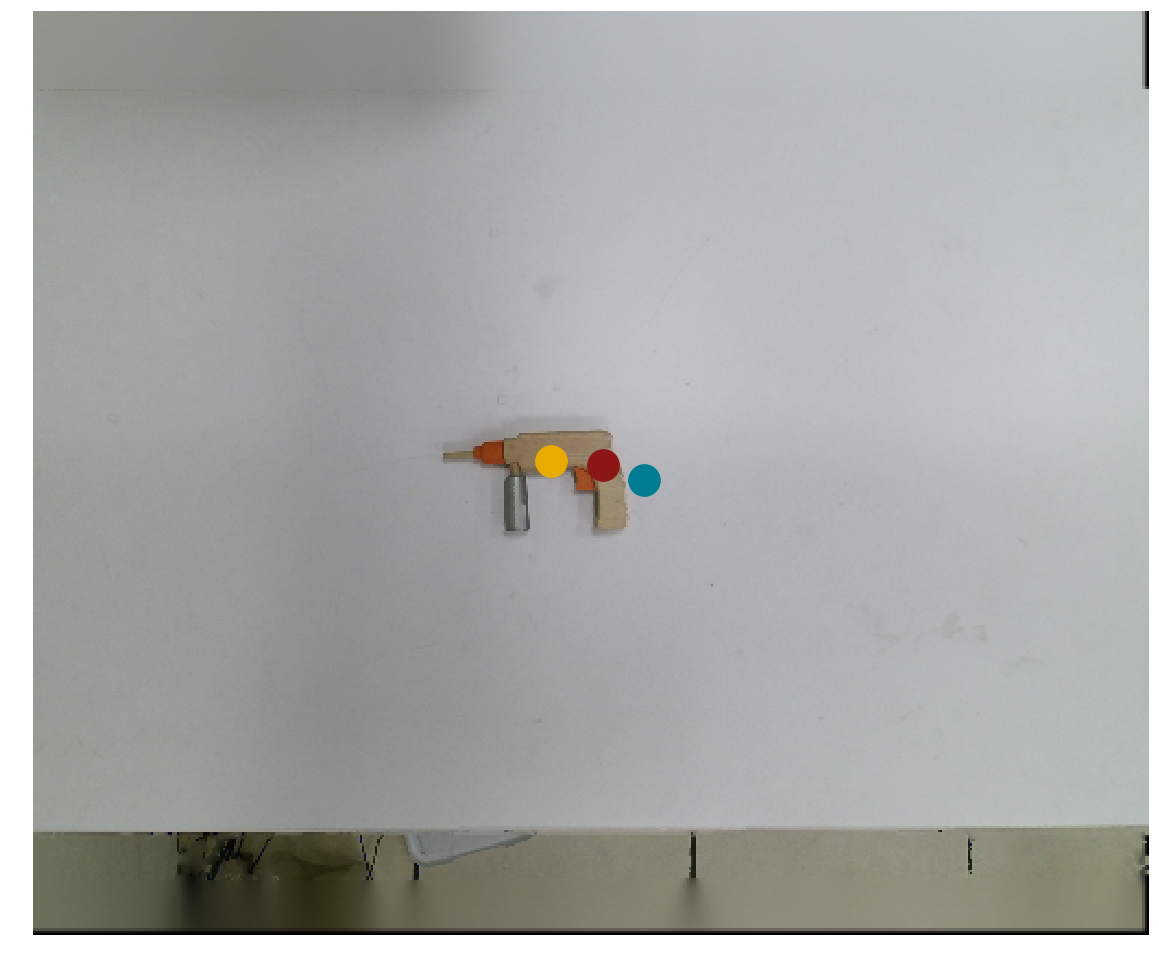

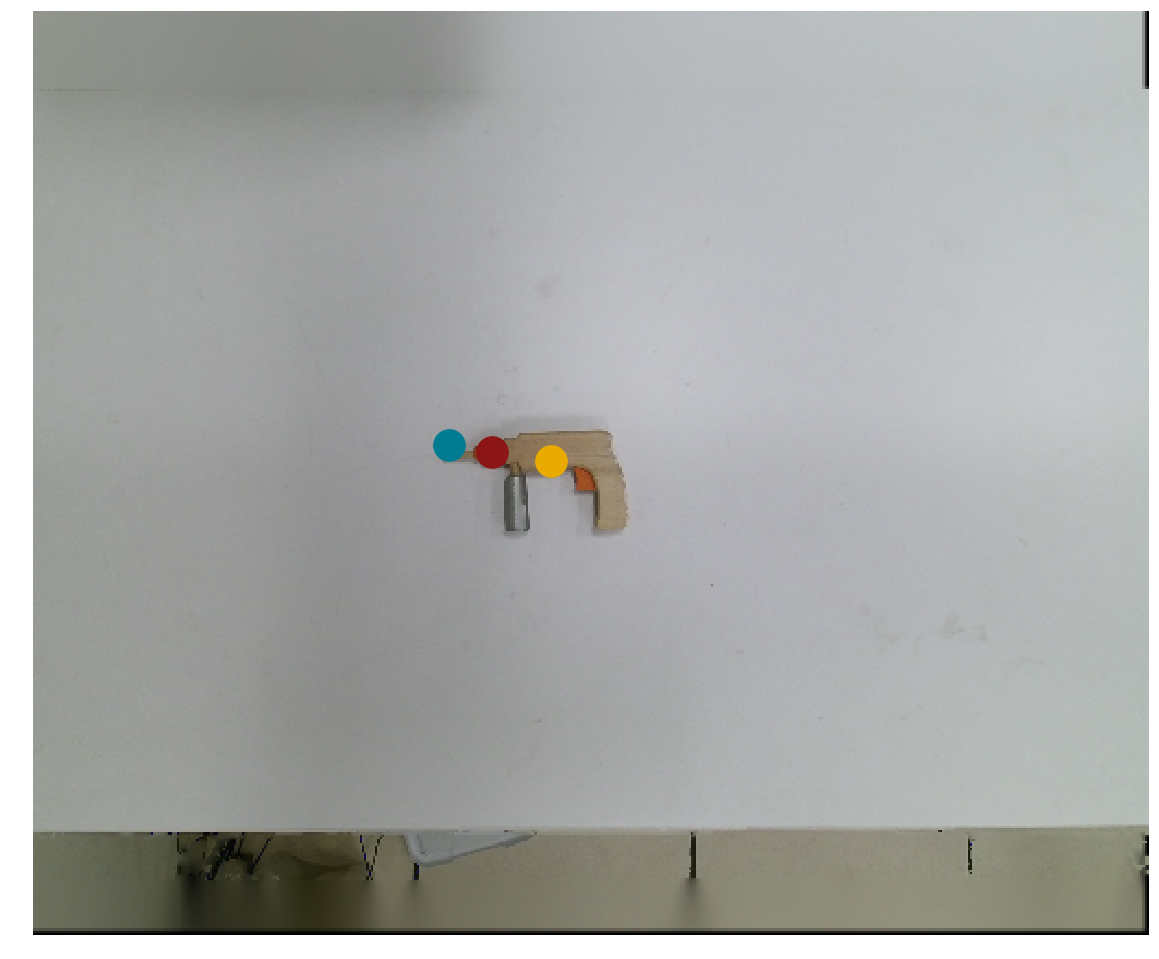

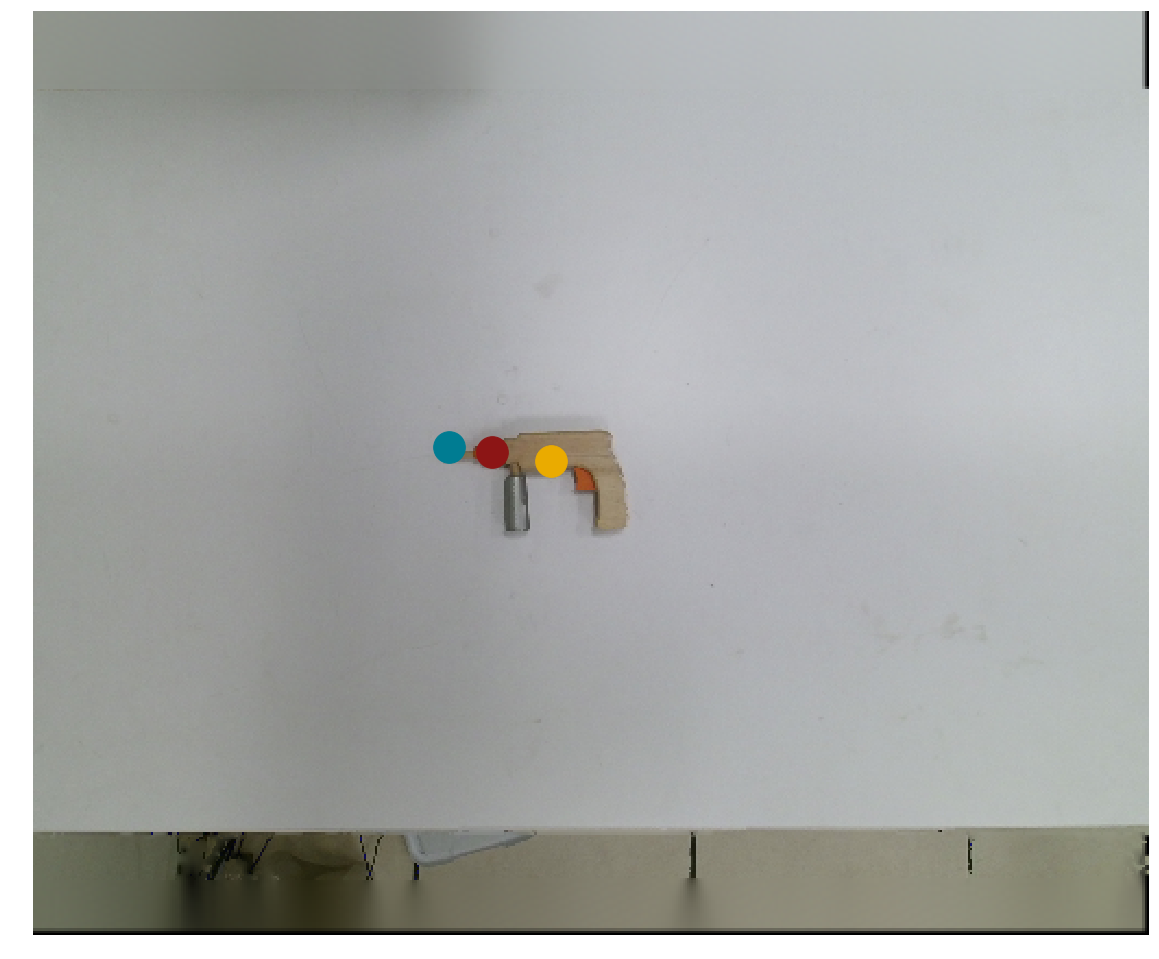

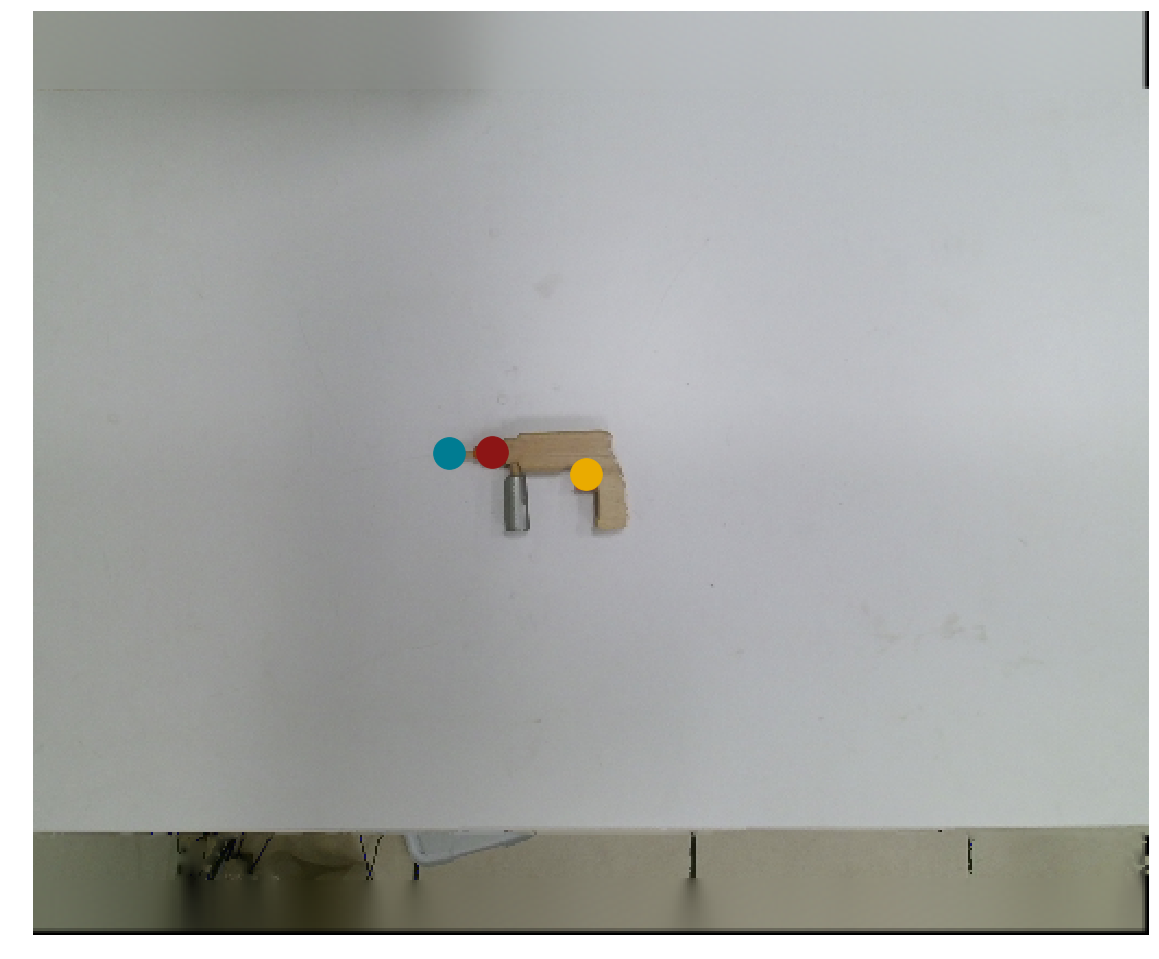

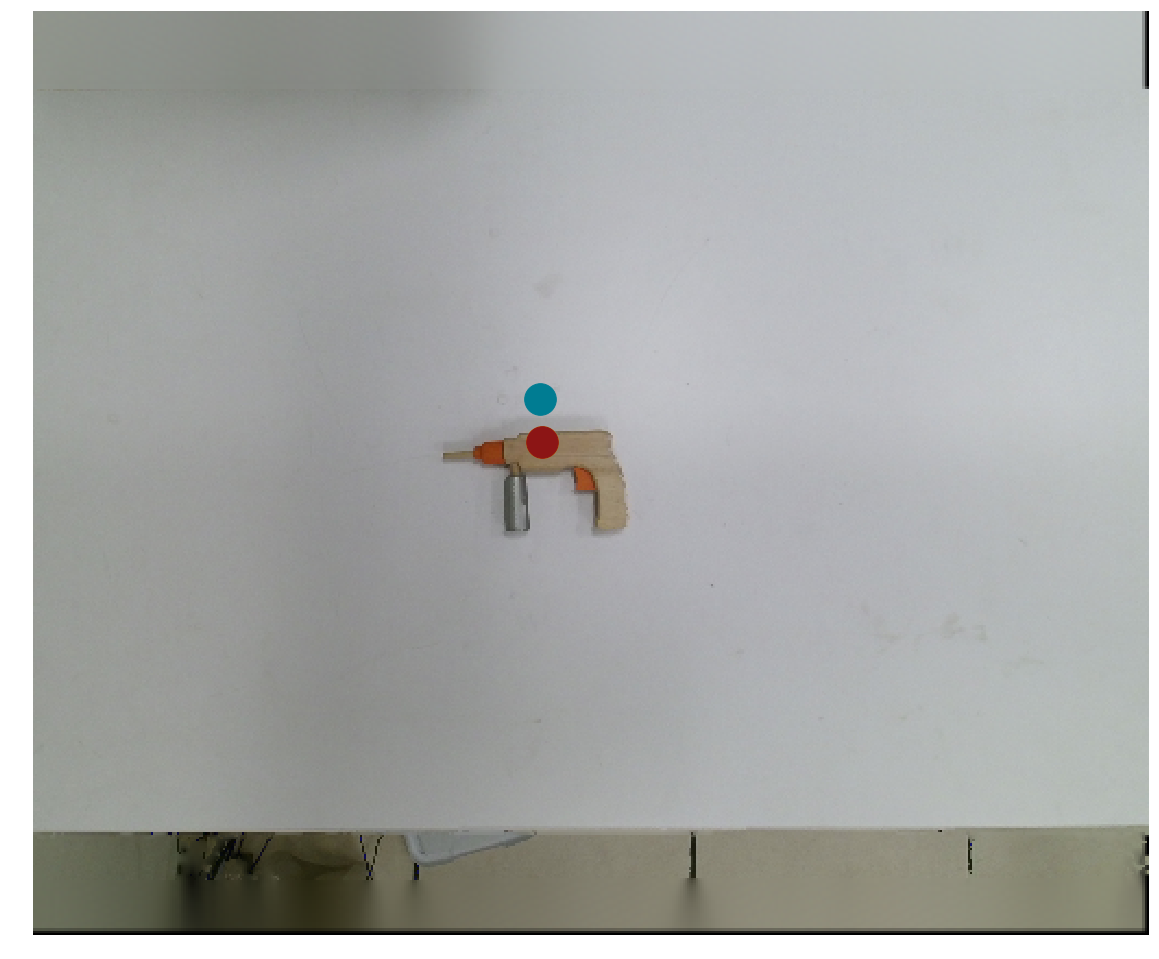

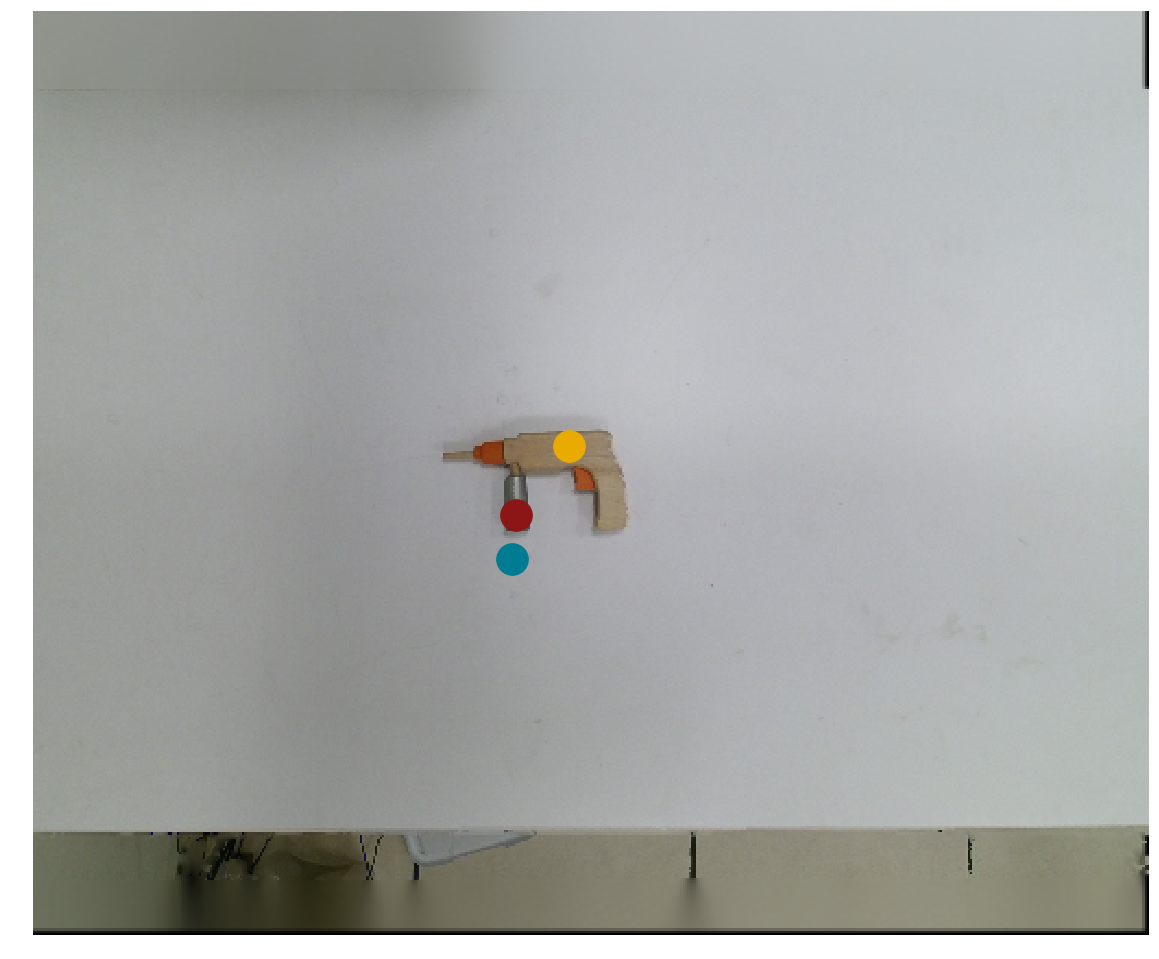

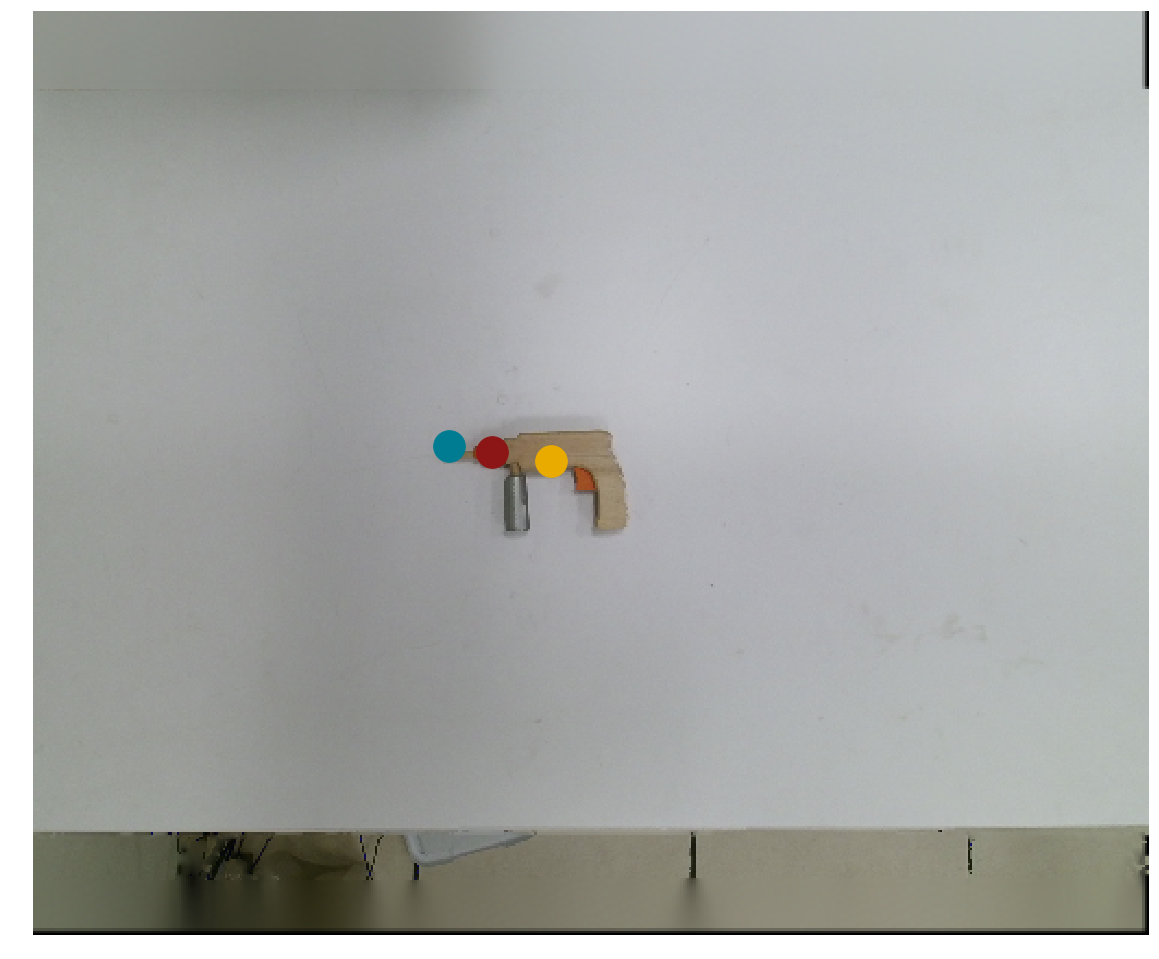

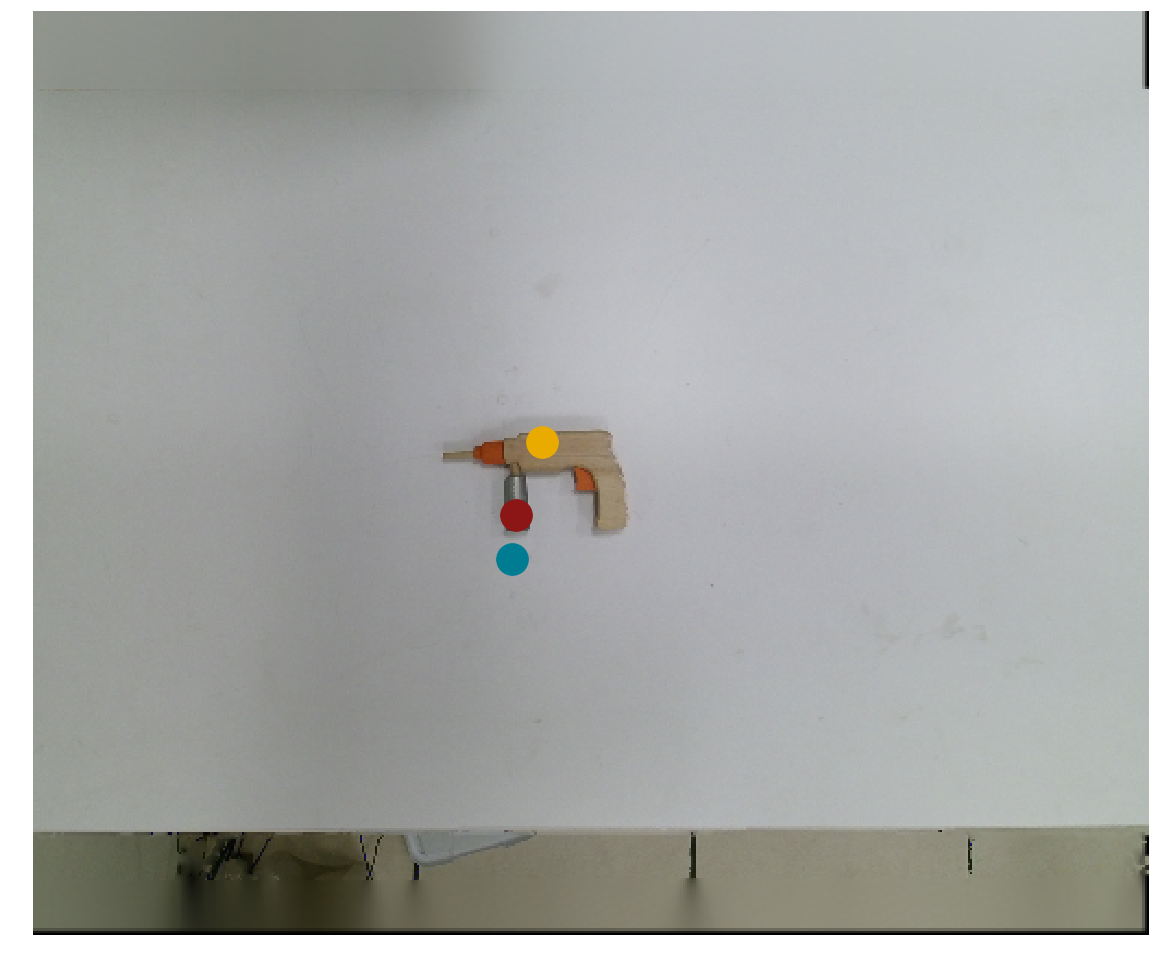

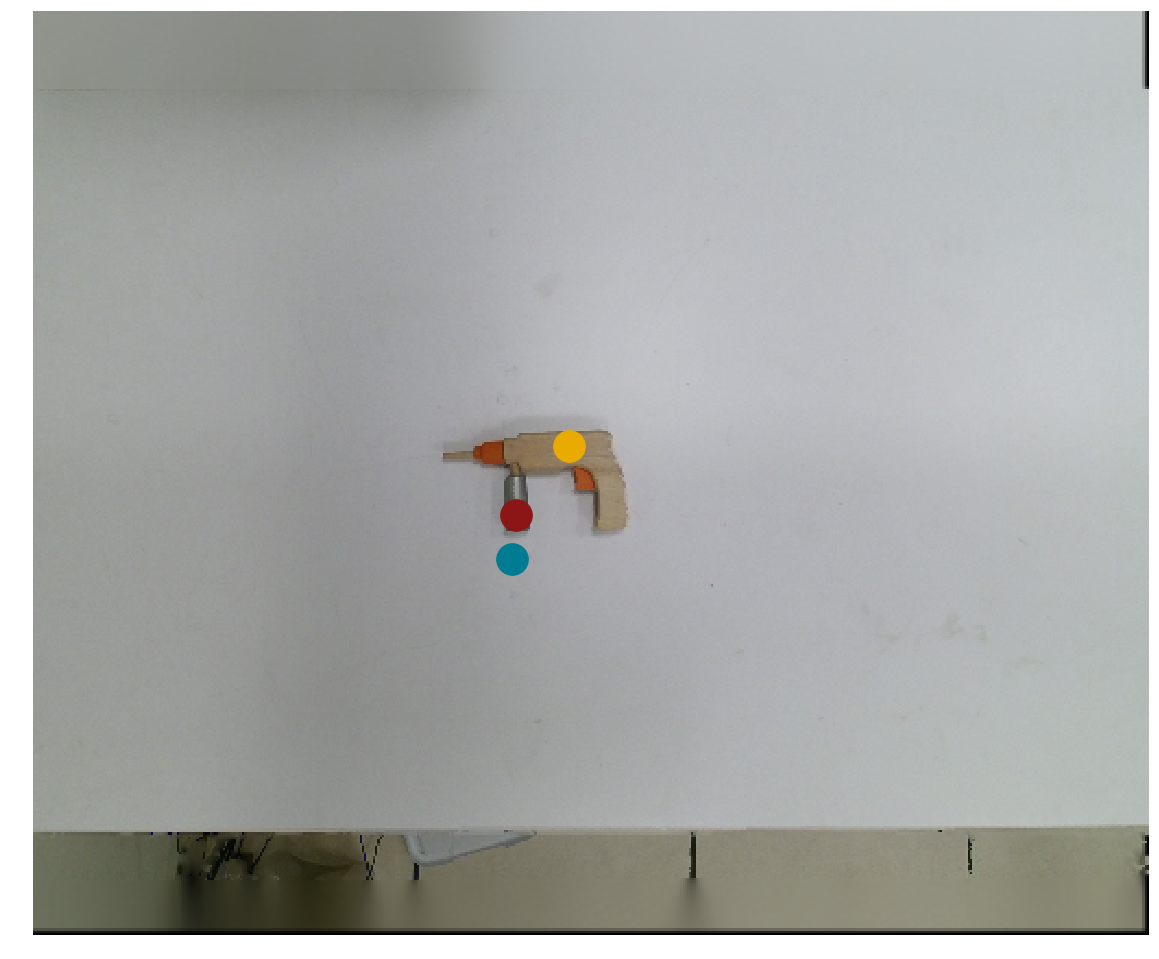

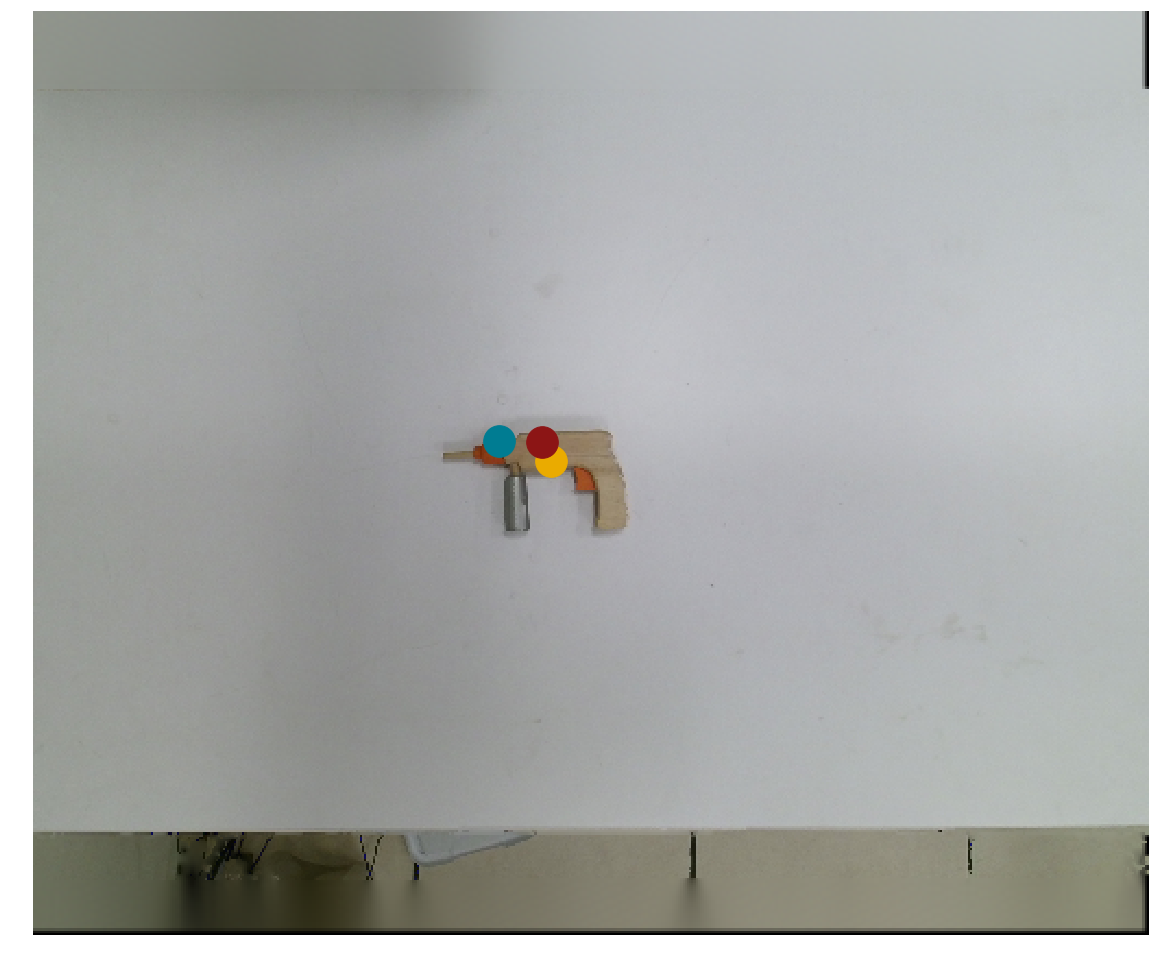

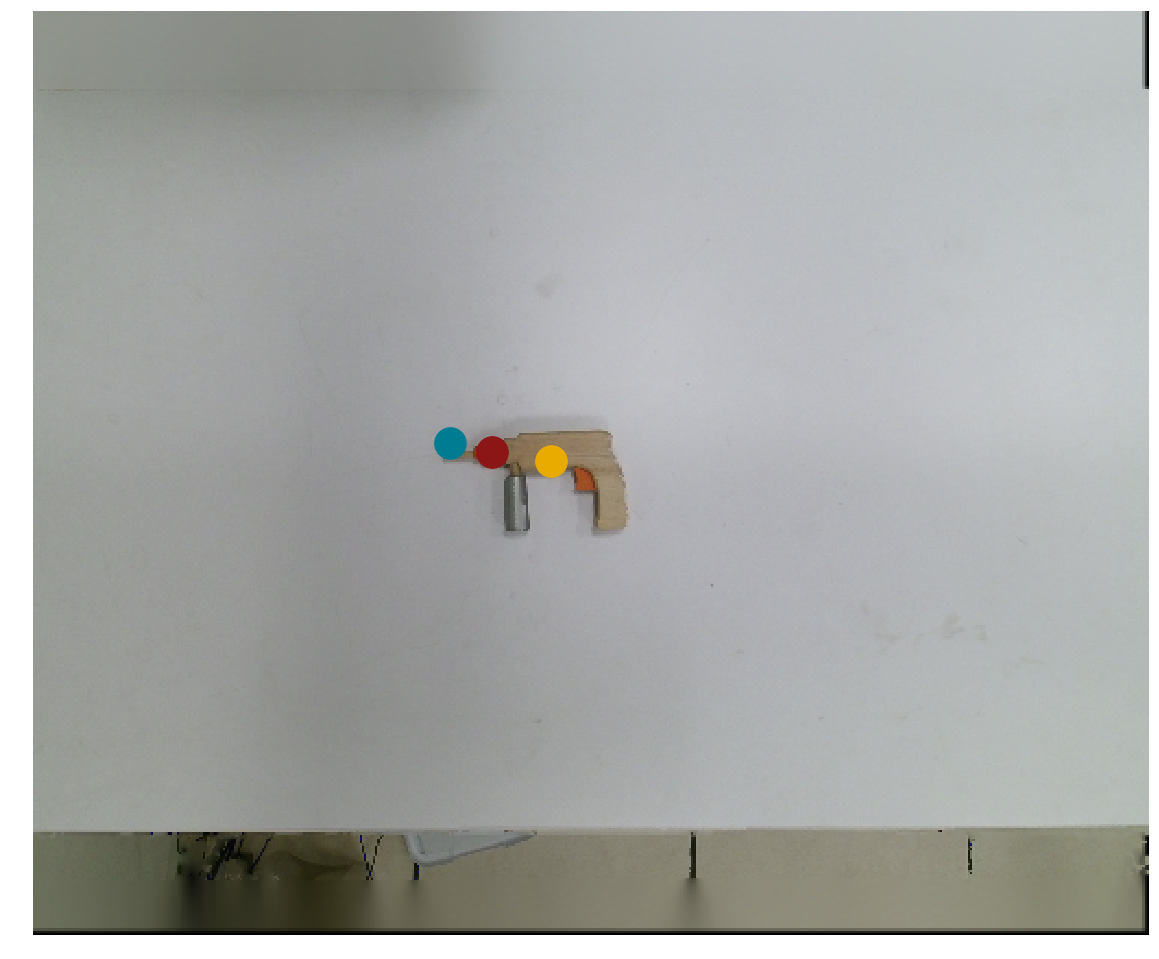

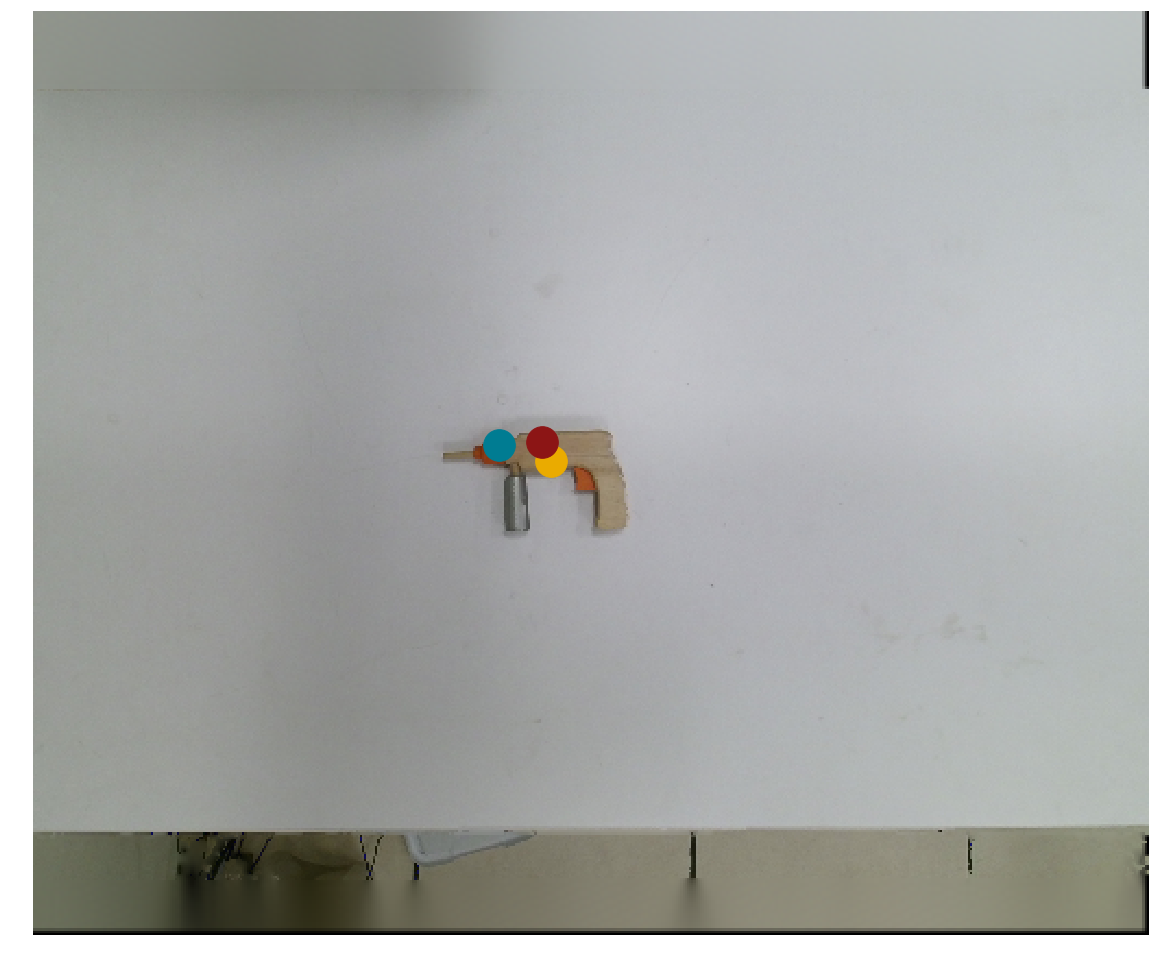

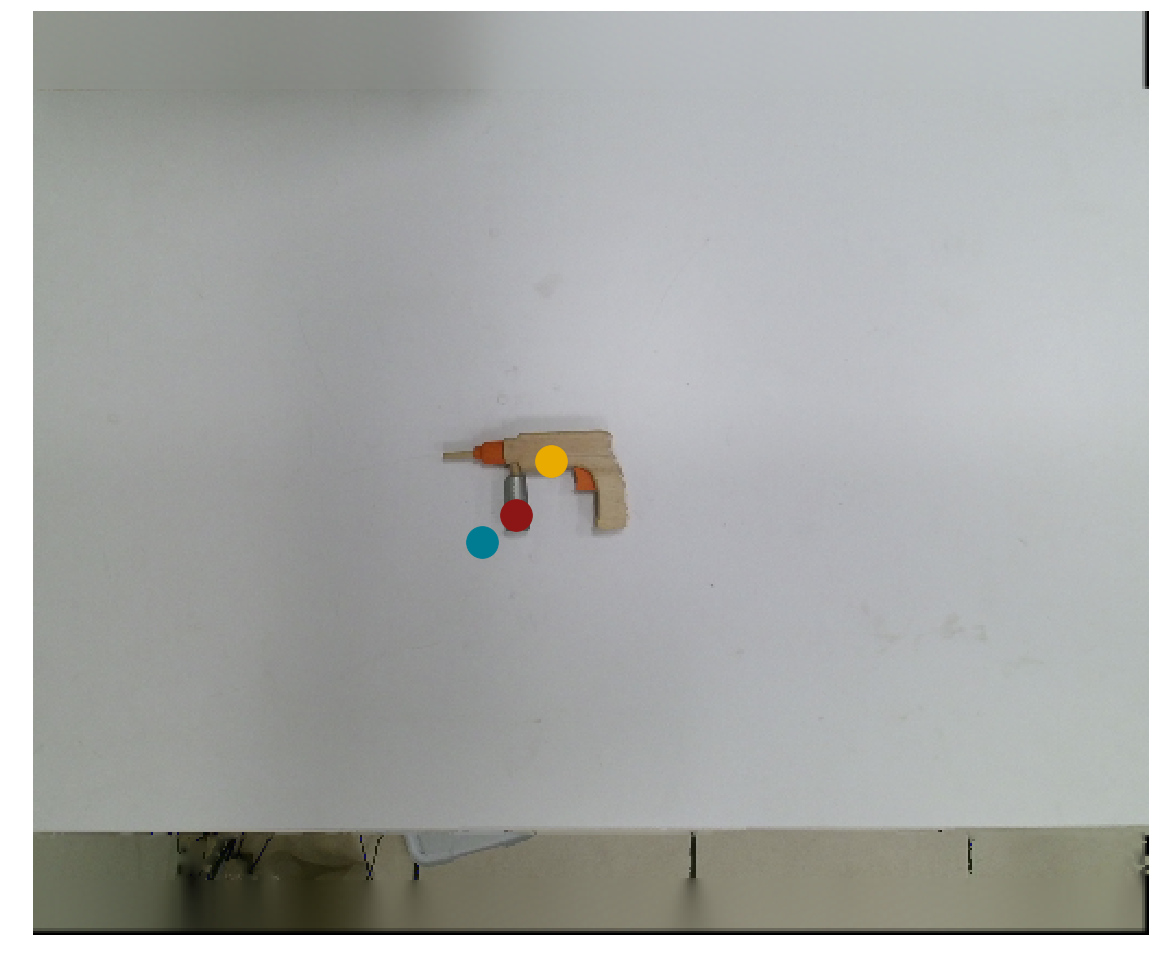

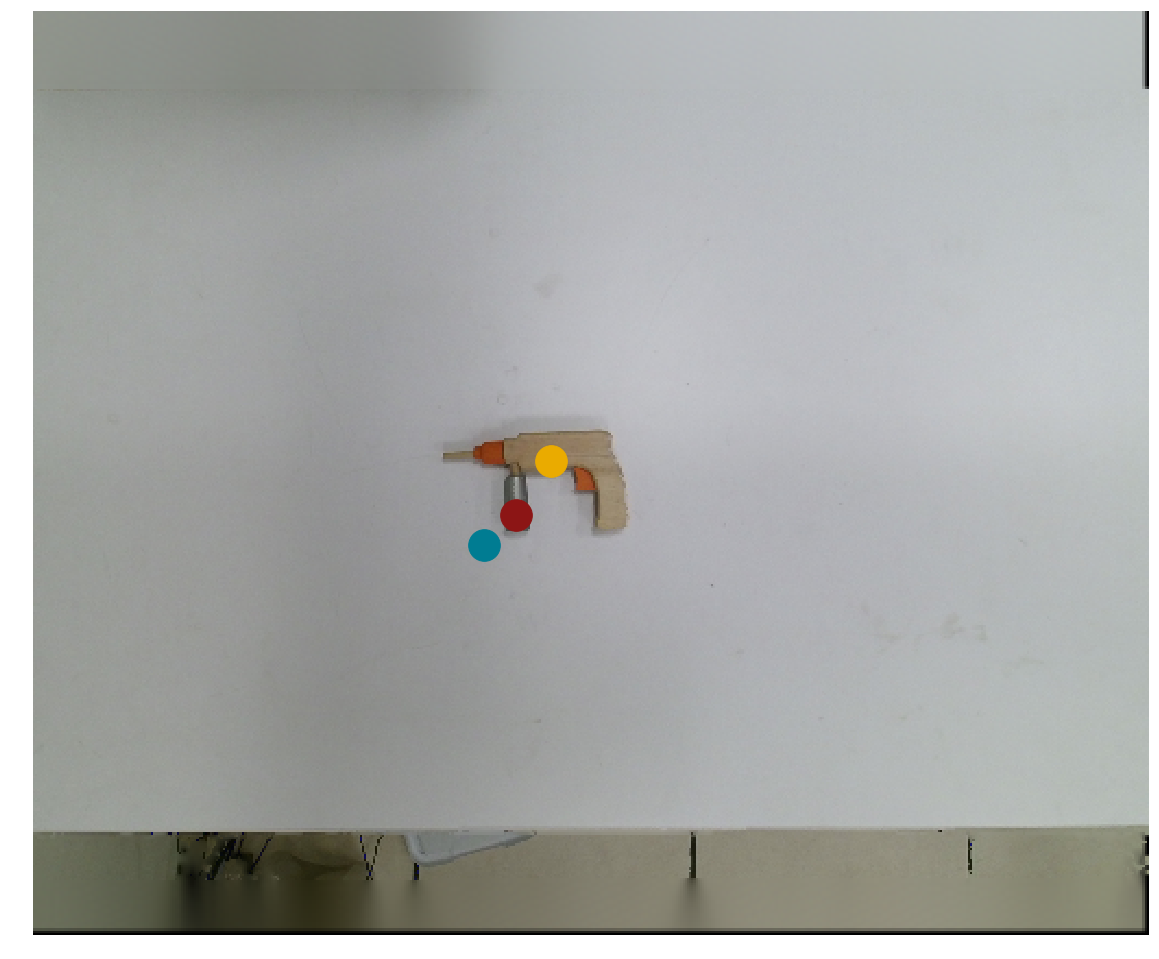

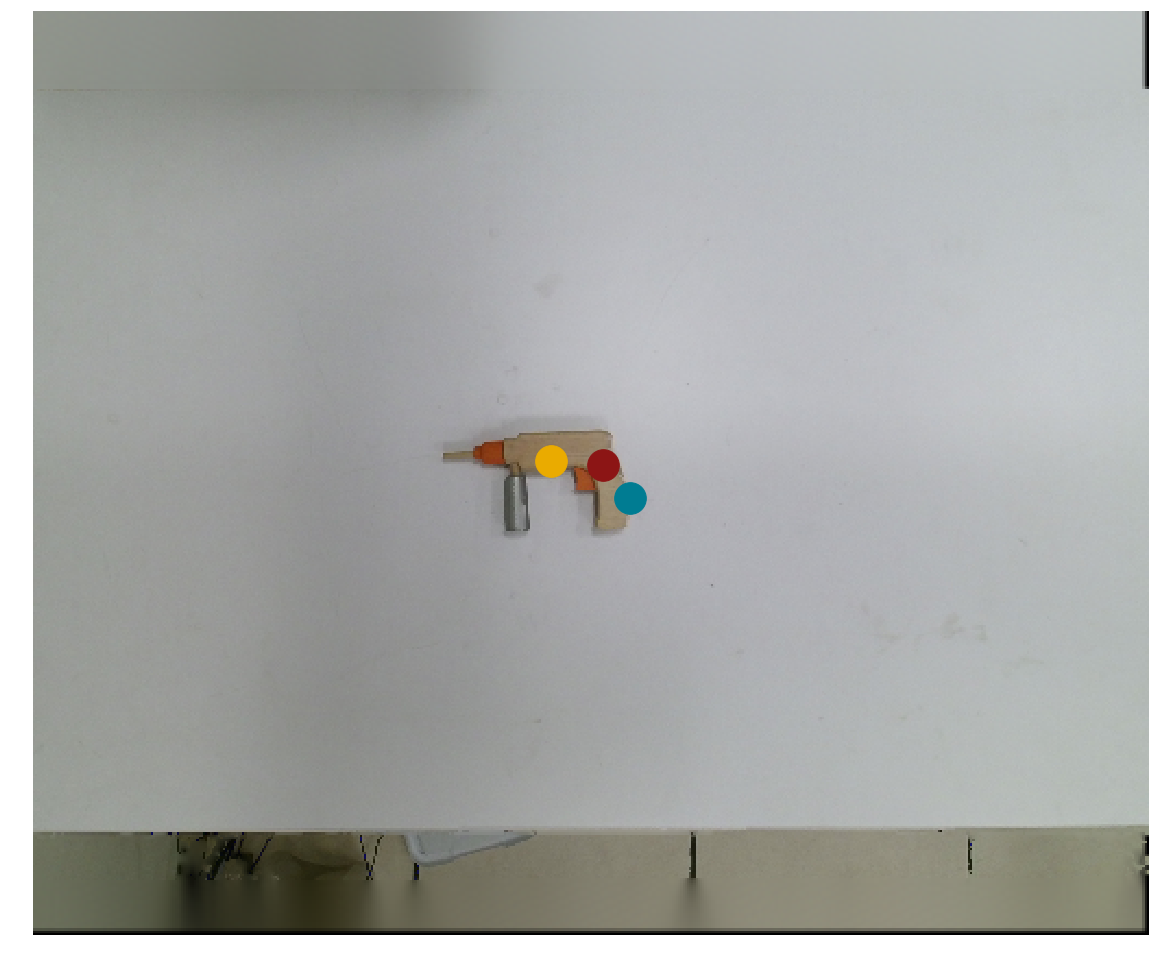

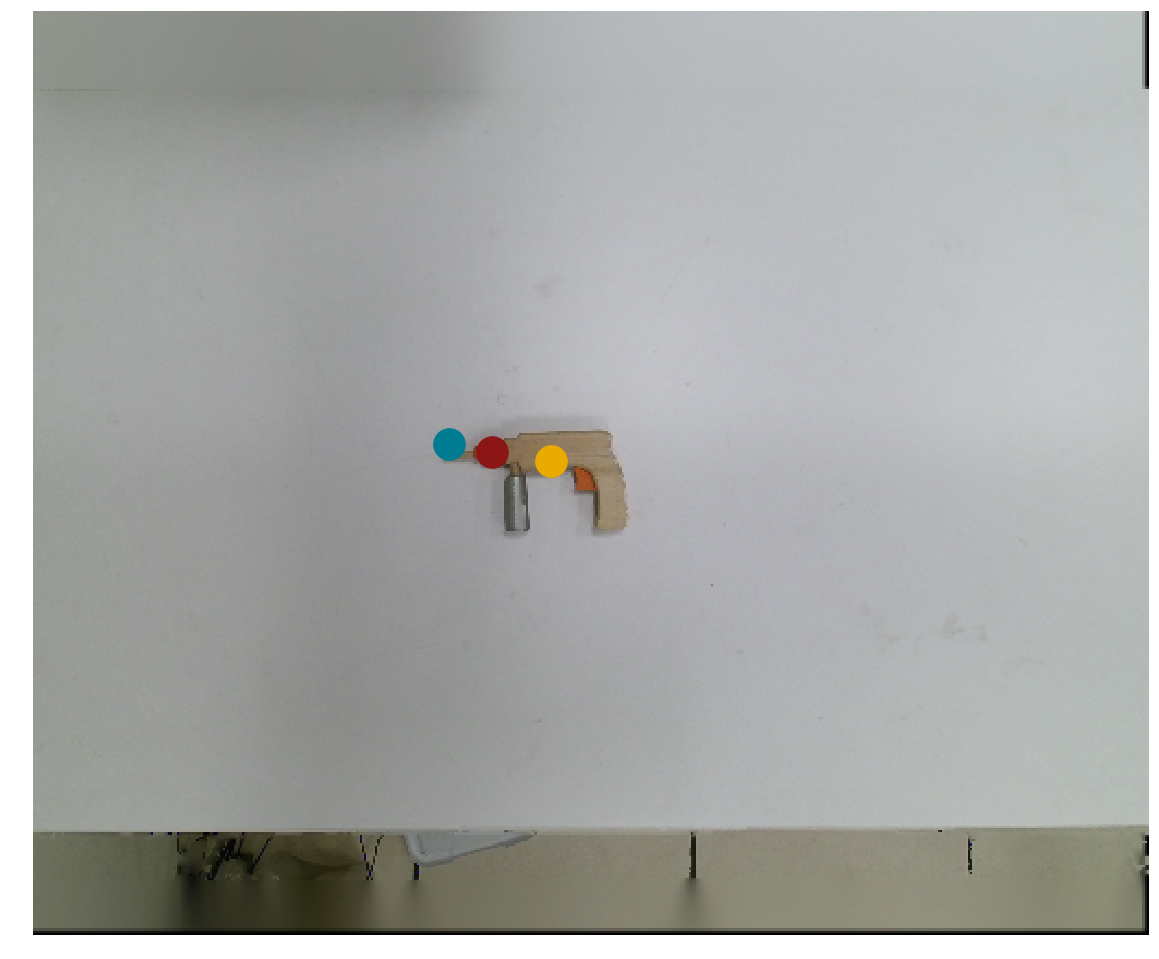

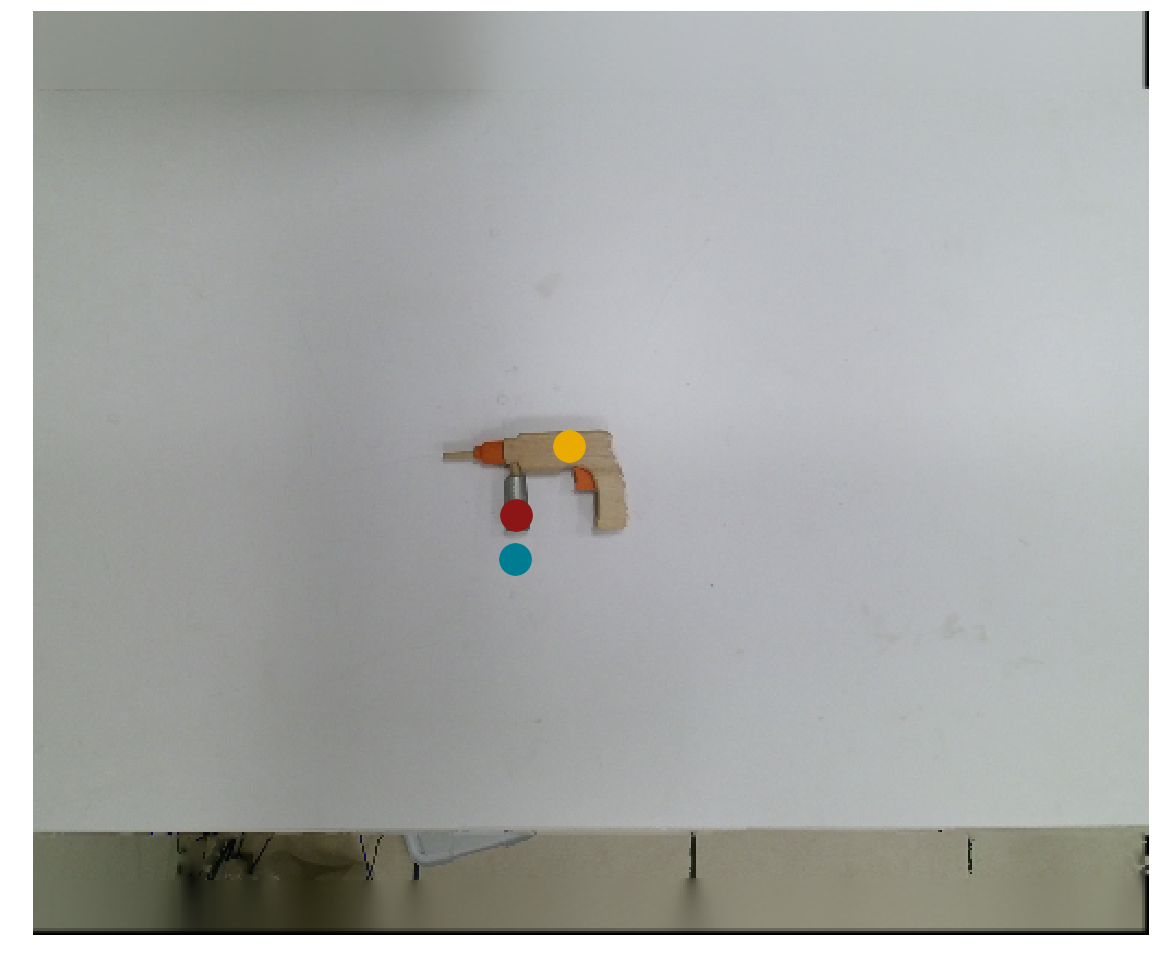

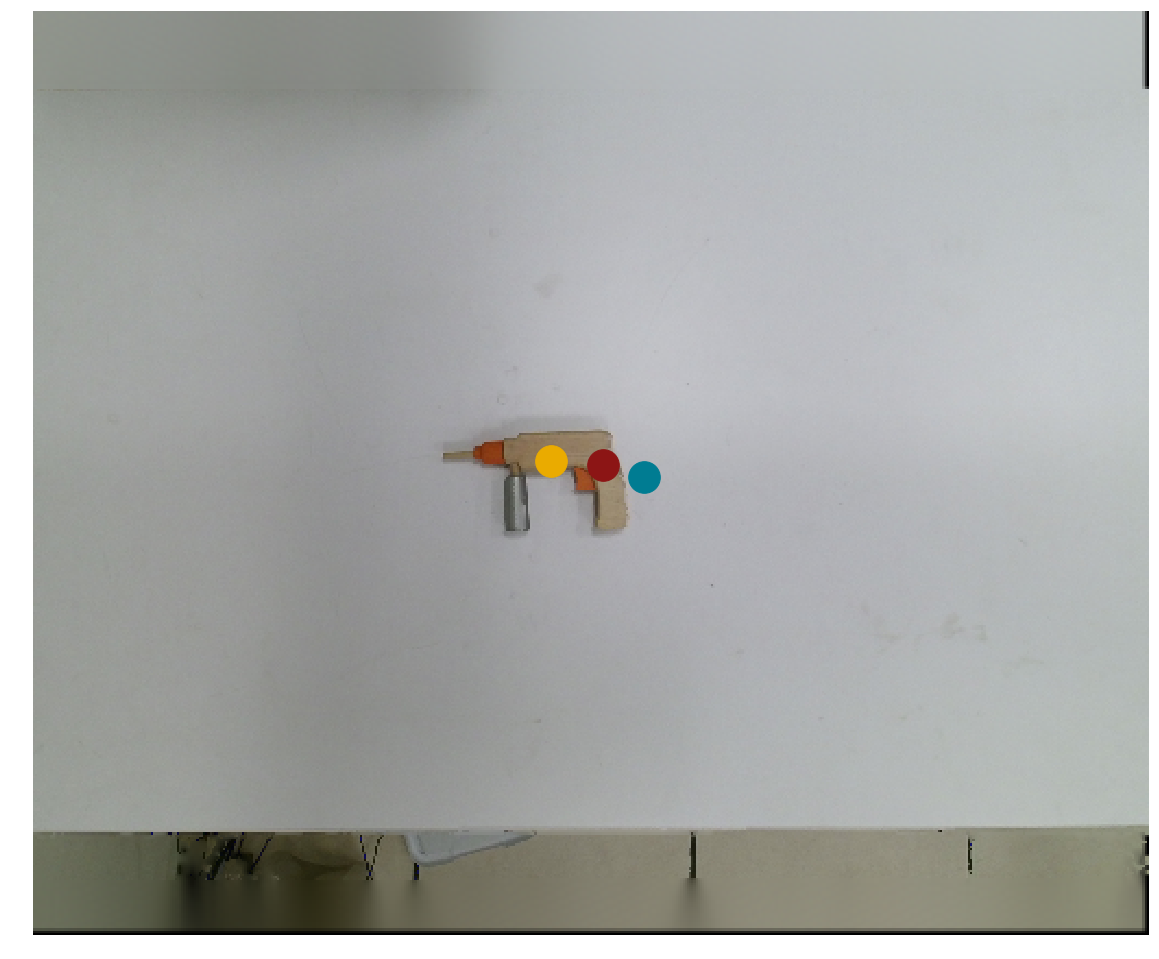

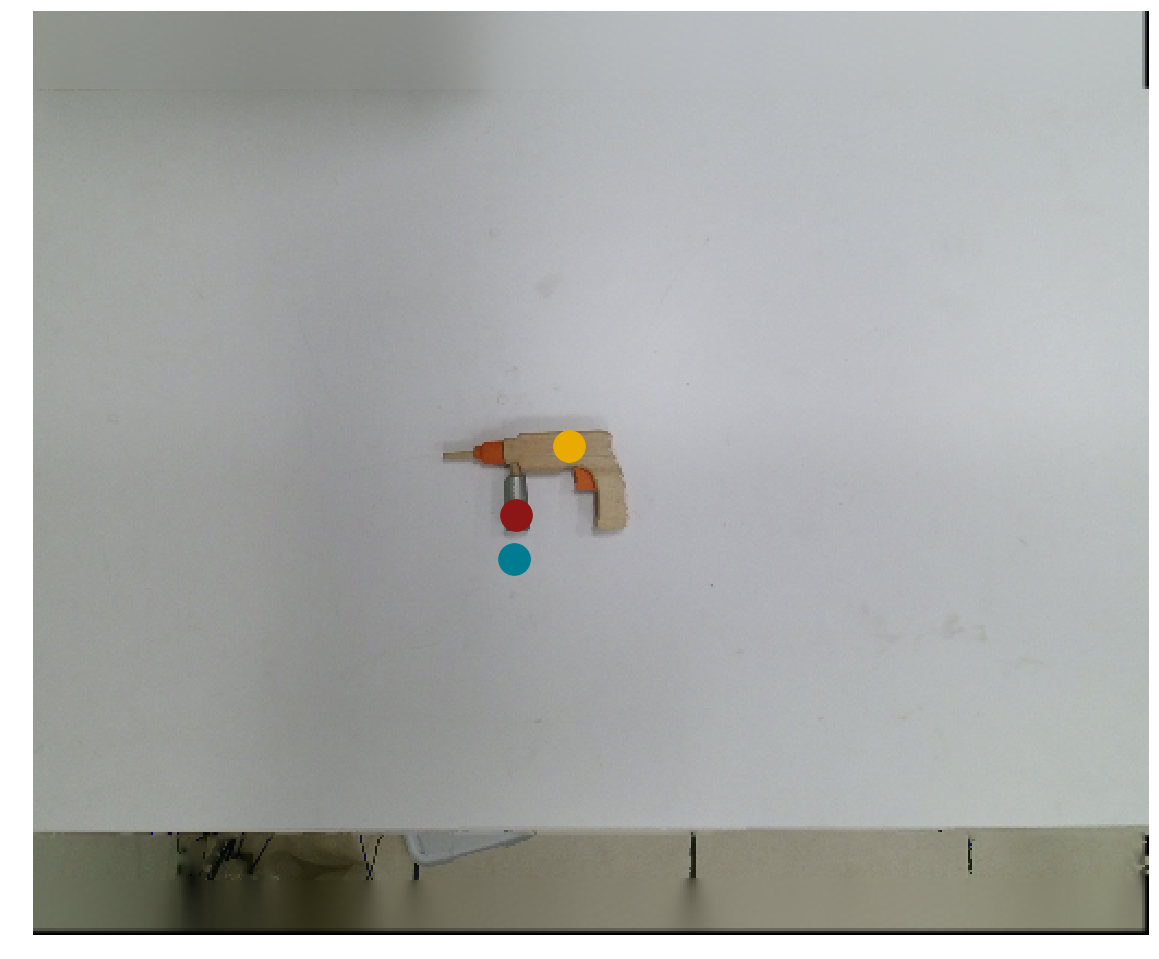

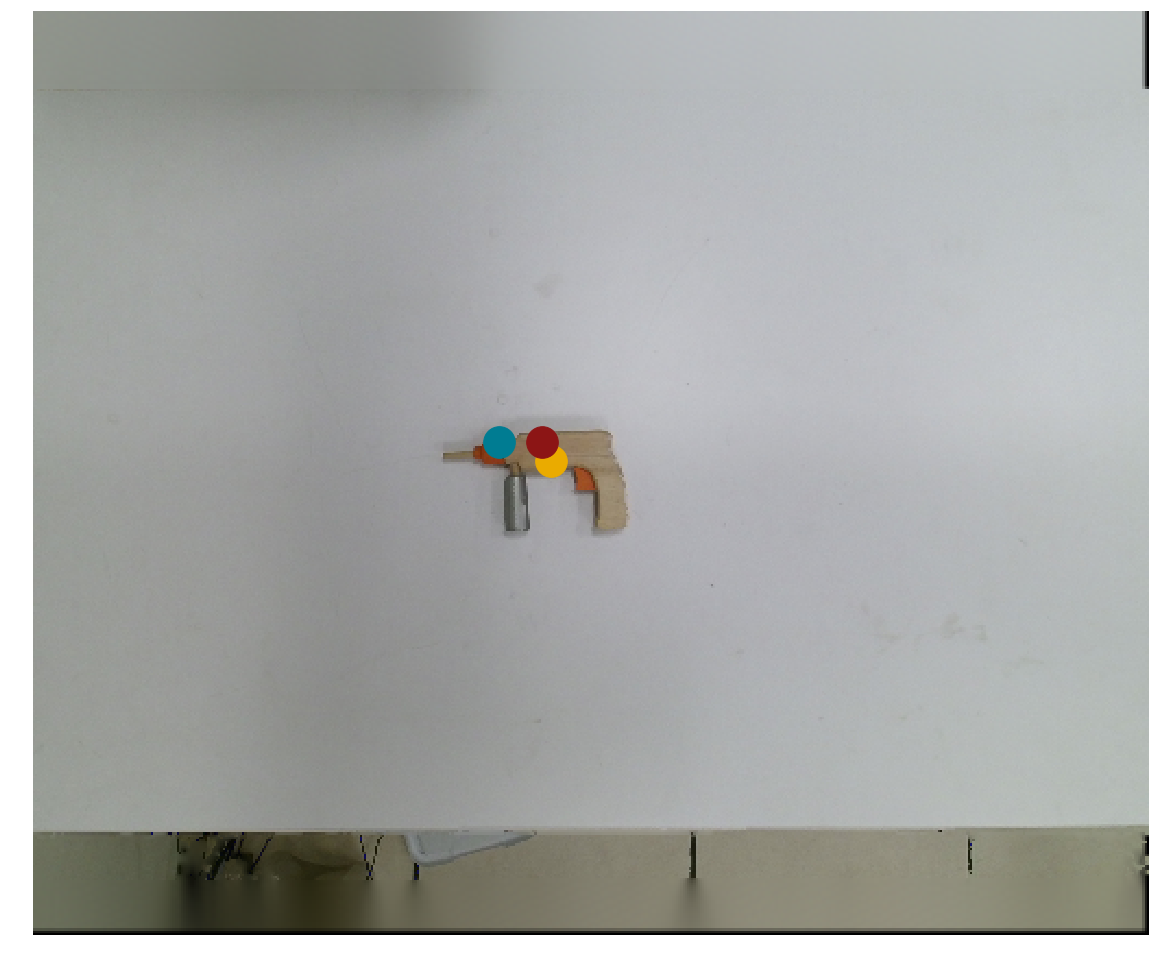

In [21]:
model_path = 'keypoint_models/cvae_reach'
max_iter = 20

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, model_path)
    for index in range(max_iter):
        keypoints_np, funct_vect_np = sess.run([top_keypoints, top_funct_vect],
            feed_dict={point_cloud_tf: point_cloud})
        visualize_keypoints_image(keypoints_np + [funct_vect_np], image, params, 'real_vis/{}_{}_{}'.format(name, 'reaching', index))